# Notebook para Análise Exploratória dos dados

In [ ]:
!pip install contractions
!pip install fastText

     |████████████████████████████████| 245kB 5.7MB/s 
     |████████████████████████████████| 317kB 28.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81706 sha256=aaec992992b20c5c84805d2a612a2c1849e6a5e14ba001b9eb09cadc4fcc311e
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for fastText: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3043339 sha256=a1900225eb863cc6779d52c93653a0ad815626be7a2d726b90b94191d2106f6b
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fastText


In [ ]:
import pandas as pd
import os
import numpy as np
import nltk   # Natural Language Toolkit
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import SnowballStemmer
from nltk.probability import FreqDist
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

Pegando o dataset do nosso repositório e colocando em um dataframe

In [ ]:
!wget https://github.com/Hannauer/mineracao_e_aprendizado_nlp/blob/main/IMDB_Dataset.zip?raw=true

--2020-11-17 18:42:52--  https://github.com/Hannauer/mineracao_e_aprendizado_nlp/blob/main/IMDB_Dataset.zip?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Hannauer/mineracao_e_aprendizado_nlp/raw/main/IMDB_Dataset.zip [following]
--2020-11-17 18:42:53--  https://github.com/Hannauer/mineracao_e_aprendizado_nlp/raw/main/IMDB_Dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hannauer/mineracao_e_aprendizado_nlp/main/IMDB_Dataset.zip [following]
--2020-11-17 18:42:53--  https://raw.githubusercontent.com/Hannauer/mineracao_e_aprendizado_nlp/main/IMDB_Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [ ]:
!unzip IMDB_Dataset.zip?raw=true

Archive:  IMDB_Dataset.zip?raw=true
  inflating: IMDB_Dataset.csv        


In [ ]:
df = pd.read_csv('IMDB_Dataset.csv', delimiter=',', error_bad_lines=False)

Começando a analisar o dataset

In [ ]:
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive


In [ ]:
# Verificando se existem valores nulos no target
df['review'].isna().sum()

0

In [ ]:
# Verificando as categorias e suas volumetrias
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
# Retirando as contrações
# Exemplo: 'there's' -> 'there is'
df['no_contract'] = df['review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df.head()

,review,sentiment,no_contract
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch...."


In [ ]:
# Transformando as descrições em linhas 
df['review_description_str'] = [' '.join(map(str, l)) for l in df['no_contract']]
df.head()

,review,sentiment,no_contract,review_description_str
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off..."


In [ ]:
# Download do punkt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenizando as palavras
# Exemplo: 'One of the other' -> 'One', 'of', 'the', 'other'
df['tokenized'] = df['review_description_str'].apply(word_tokenize)
df.head()

,review,sentiment,no_contract,review_description_str,tokenized
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to..."


In [ ]:
# Convertendo todos os caracter para lower case
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])
df.head()

,review,sentiment,no_contract,review_description_str,tokenized,lower
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, ., the, filming, technique, is, very, unassuming-, very, old-..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, (, jake, ), thinks, there, is, a, zombi..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to..."


In [ ]:
# Removendo pontuação
punc = string.punctuation
df['no_punc'] = df['lower'].apply(lambda x: [word for word in x if word not in punc])
df.head()

,review,sentiment,no_contract,review_description_str,tokenized,lower,no_punc
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, ., the, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, the, filming, technique, is, very, unassuming-, very, old-tim..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, si..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, (, jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, jake, thinks, there, is, a, zombie, in,..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to..."


In [ ]:
# Download do dic de stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removendo stop words
# Exemplo: Remoção de palavras como 'of', 'the', 'is'...
stop_words = set(stopwords.words('english'))
df['stopwords_removed'] = df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,review,sentiment,no_contract,review_description_str,tokenized,lower,no_punc,stopwords_removed
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, reviewers, mentioned, watching, 1, oz, episode, hooked, right, exactly, happened, first, t..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, ., the, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, the, filming, technique, is, very, unassuming-, very, old-tim...","[wonderful, little, production, filming, technique, unassuming-, old-time-bbc, fashion, gives, c..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, si...","[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater,..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, (, jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, jake, thinks, there, is, a, zombie, in,...","[basically, family, little, boy, jake, thinks, zombie, closet, parents, fighting, time, movie, s..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, time, money, '', visually, stunning, film, watch, mr., mattei, of..."


In [ ]:
# Aplicando o stemmer nas palavras
# Exemplo: 'fighting' -> 'fight' ; 'wonderful' -> 'wonder'
stemmer = SnowballStemmer(language='english')
df['stemmed'] = df['stopwords_removed'].apply(lambda x: [stemmer.stem(word) for word in x])
df.head()

,review,sentiment,no_contract,review_description_str,tokenized,lower,no_punc,stopwords_removed,stemmed
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, reviewers, mentioned, watching, 1, oz, episode, hooked, right, exactly, happened, first, t...","[one, review, mention, watch, 1, oz, episod, hook, right, exact, happen, first, thing, struck, o..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, ., the, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, the, filming, technique, is, very, unassuming-, very, old-tim...","[wonderful, little, production, filming, technique, unassuming-, old-time-bbc, fashion, gives, c...","[wonder, littl, product, film, techniqu, unassuming-, old-time-bbc, fashion, give, comfort, some..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, si...","[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater,...","[thought, wonder, way, spend, time, hot, summer, weekend, sit, air, condit, theater, watch, ligh..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, (, jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, jake, thinks, there, is, a, zombie, in,...","[basically, family, little, boy, jake, thinks, zombie, closet, parents, fighting, time, movie, s...","[basic, famili, littl, boy, jake, think, zombi, closet, parent, fight, time, movi, slower, soap,..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually,

In [ ]:
# Analisando o numero de tokens
df['stemmed'].str.len().describe()

count    50000.000000
mean       122.885240
std         93.126309
min          3.000000
25%         65.000000
50%         91.000000
75%        149.000000
max       1449.000000
Name: stemmed, dtype: float64

In [ ]:
print(df.loc[df.sentiment == 'positive', 'stemmed'].str.len().describe())
print(df.loc[df.sentiment == 'negative', 'stemmed'].str.len().describe())

count    25000.000000
mean       124.570520
std         97.407771
min          6.000000
25%         64.000000
50%         91.000000
75%        152.000000
max       1449.000000
Name: stemmed, dtype: float64
count    25000.000000
mean       121.199960
std         88.608192
min          3.000000
25%         66.000000
50%         92.000000
75%        147.000000
max        868.000000
Name: stemmed, dtype: float64


In [ ]:
# Curiosidade: achando o review com menos tokens
print(df['stemmed'].str.len().idxmin())
df.loc[31072]

31072


review                                    What a script, what a story, what a mess!
sentiment                                                                  negative
no_contract                     [What, a, script,, what, a, story,, what, a, mess!]
review_description_str                    What a script, what a story, what a mess!
tokenized                 [What, a, script, ,, what, a, story, ,, what, a, mess, !]
lower                     [what, a, script, ,, what, a, story, ,, what, a, mess, !]
no_punc                            [what, a, script, what, a, story, what, a, mess]
stopwords_removed                                             [script, story, mess]
stemmed                                                       [script, stori, mess]
Name: 31072, dtype: object

Testando coeficiente de sentimento

In [ ]:
# Gerando coeficiente de sentimento
df_processed = df[['stemmed', 'sentiment']]

df_processed['stemmed_str'] = [' '.join(map(str,l)) for l in df['stemmed']]

df_processed['sentiment_score'] = df_processed['stemmed_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_processed.head()

,stemmed,sentiment,stemmed_str,sentiment_score
0,"[one, review, mention, watch, 1, oz, episod, hook, right, exact, happen, first, thing, struck, o...",positive,one review mention watch 1 oz episod hook right exact happen first thing struck oz brutal unflin...,0.025782
1,"[wonder, littl, product, film, techniqu, unassuming-, old-time-bbc, fashion, give, comfort, some...",positive,wonder littl product film techniqu unassuming- old-time-bbc fashion give comfort sometim discomf...,0.215476
2,"[thought, wonder, way, spend, time, hot, summer, weekend, sit, air, condit, theater, watch, ligh...",positive,thought wonder way spend time hot summer weekend sit air condit theater watch light-heart comedi...,0.372619
3,"[basic, famili, littl, boy, jake, think, zombi, closet, parent, fight, time, movi, slower, soap,...",negative,basic famili littl boy jake think zombi closet parent fight time movi slower soap opera ... sudd...,0.056250
4,"[petter, mattei, 's, ``, love, time, money, '', visual, stun, film, watch, mr., mattei, offer, u...",positive,petter mattei 's `` love time money '' visual stun film watch mr. mattei offer us vivid portrait...,0.193974


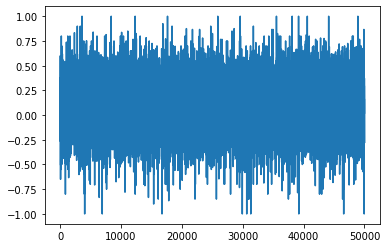

In [ ]:
df_processed.sentiment_score.plot()

In [ ]:
df_processed_positive = df_processed[df_processed.sentiment_score > 0]
df_processed_negative = df_processed[df_processed.sentiment_score <= 0]

In [ ]:
df_processed_positive.sentiment.value_counts() # Precisão -> 22512 / 22512+15124 = 0.60

positive    22512
negative    15124
Name: sentiment, dtype: int64

In [ ]:
df_processed_negative.sentiment.value_counts() # Precisão -> 9876 / 9876+2488 = 0.80

negative    9876
positive    2488
Name: sentiment, dtype: int64

(array([9.0000e+00, 1.1000e+01, 2.4000e+01, 4.0000e+01, 8.2000e+01,
        2.2900e+02, 4.6200e+02, 1.1750e+03, 3.0260e+03, 7.0930e+03,
        1.2484e+04, 1.2071e+04, 7.3990e+03, 3.5560e+03, 1.3330e+03,
        6.7600e+02, 2.2000e+02, 5.3000e+01, 4.4000e+01, 1.3000e+01]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

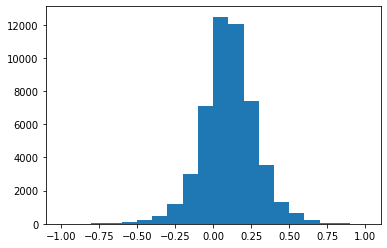

In [ ]:
plt.hist(df_processed.sentiment_score, bins=20)

Ocorrências de palavras

In [ ]:
reviews_tokens = df_processed['stemmed']
all_words = []
for review in reviews_tokens:
  all_words += review

print(len(all_words))
print(all_words[0:100])

6144262
['one', 'review', 'mention', 'watch', '1', 'oz', 'episod', 'hook', 'right', 'exact', 'happen', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'main', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'many..aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', '...', '.so', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'dare', 'forget', 'pretti', 'pictur', 'paint']


In [ ]:
#from wordcloud import WordCloud

In [ ]:
common_words = FreqDist(all_words).most_common(100)
print(common_words[0:10])

#wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(common_words))
#plt.imshow(wordcloud, interpolation="bilinear")


[('movi', 101477), ('film', 94357), ('``', 66062), ("''", 65946), ("'s", 63088), ('one', 54020), ('like', 44234), ('would', 31019), ('time', 30866), ('good', 29482)]


In [ ]:
def plotCommonWords(word_freq, title):
  x, y = zip(*word_freq)

  plt.figure(figsize=(50,20))
  plt.bar(x, y)
  plt.xticks(rotation= 45, fontsize=45)
  plt.yticks(fontsize=45)
  plt.title(title, fontsize=100)
  plt.show()

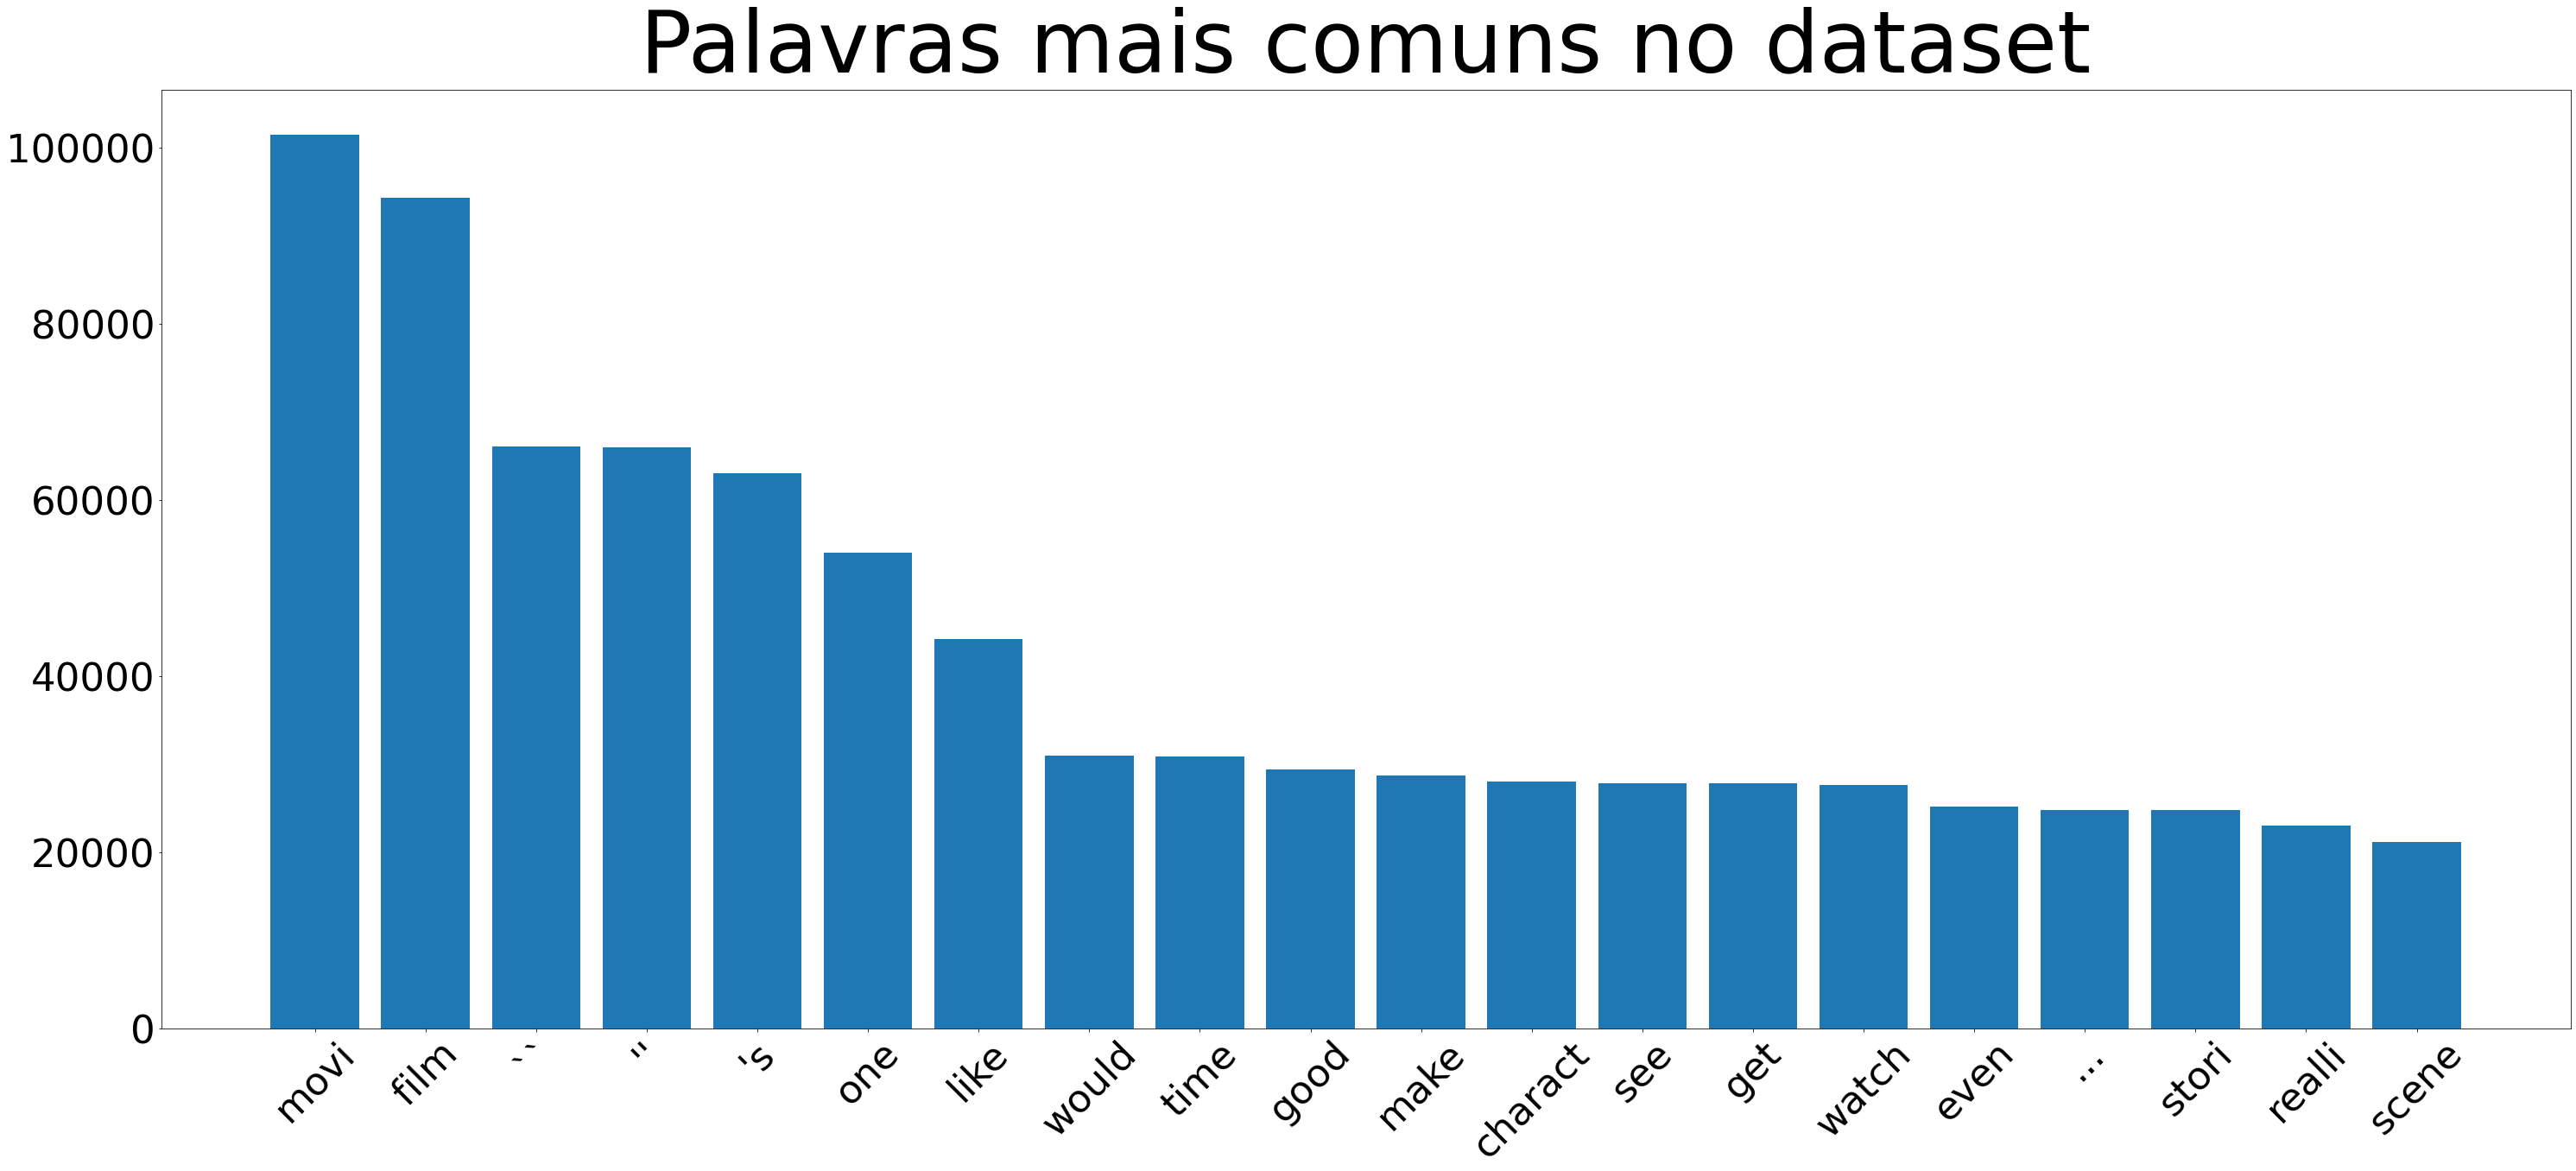

In [ ]:
plotCommonWords(common_words[0:20], 'Palavras mais comuns no dataset')

In [ ]:
positive_reviews_tokens = df_processed.loc[df_processed.sentiment == 'positive', 'stemmed']
positive_all_words = []
for review in positive_reviews_tokens:
  positive_all_words += review

positive_common_words = FreqDist(positive_all_words).most_common(100)

negative_reviews_tokens = df_processed.loc[df_processed.sentiment == 'negative', 'stemmed']
negative_all_words = []
for review in negative_reviews_tokens:
  negative_all_words += review

negative_common_words = FreqDist(negative_all_words).most_common(100)

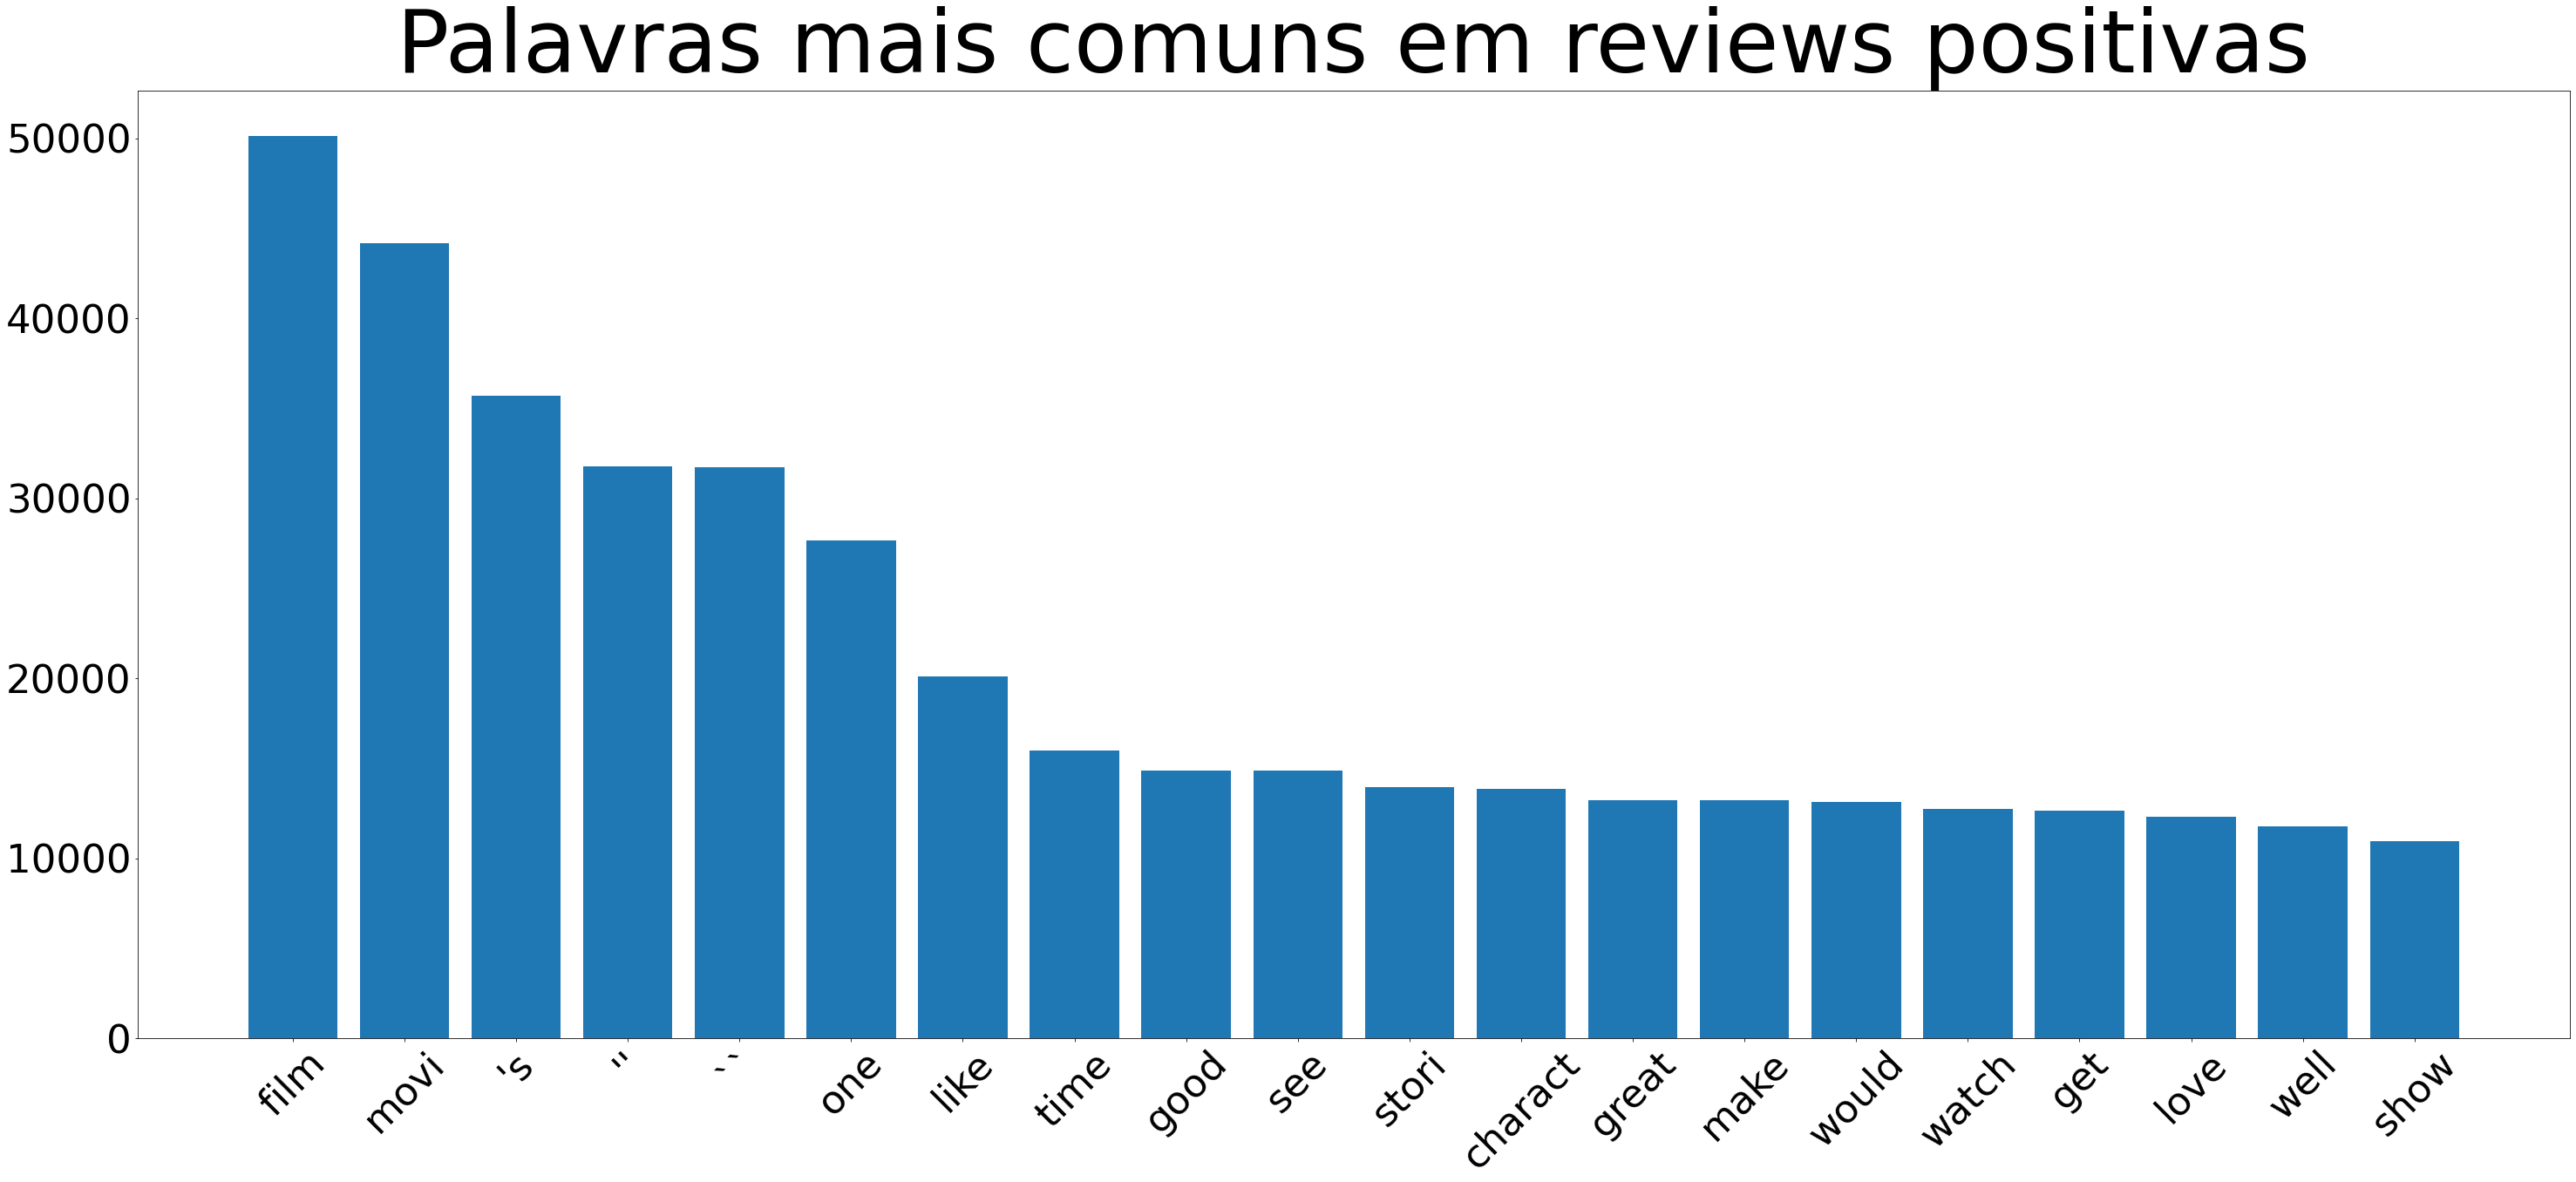

In [ ]:
plotCommonWords(positive_common_words[0:20], 'Palavras mais comuns em reviews positivas')

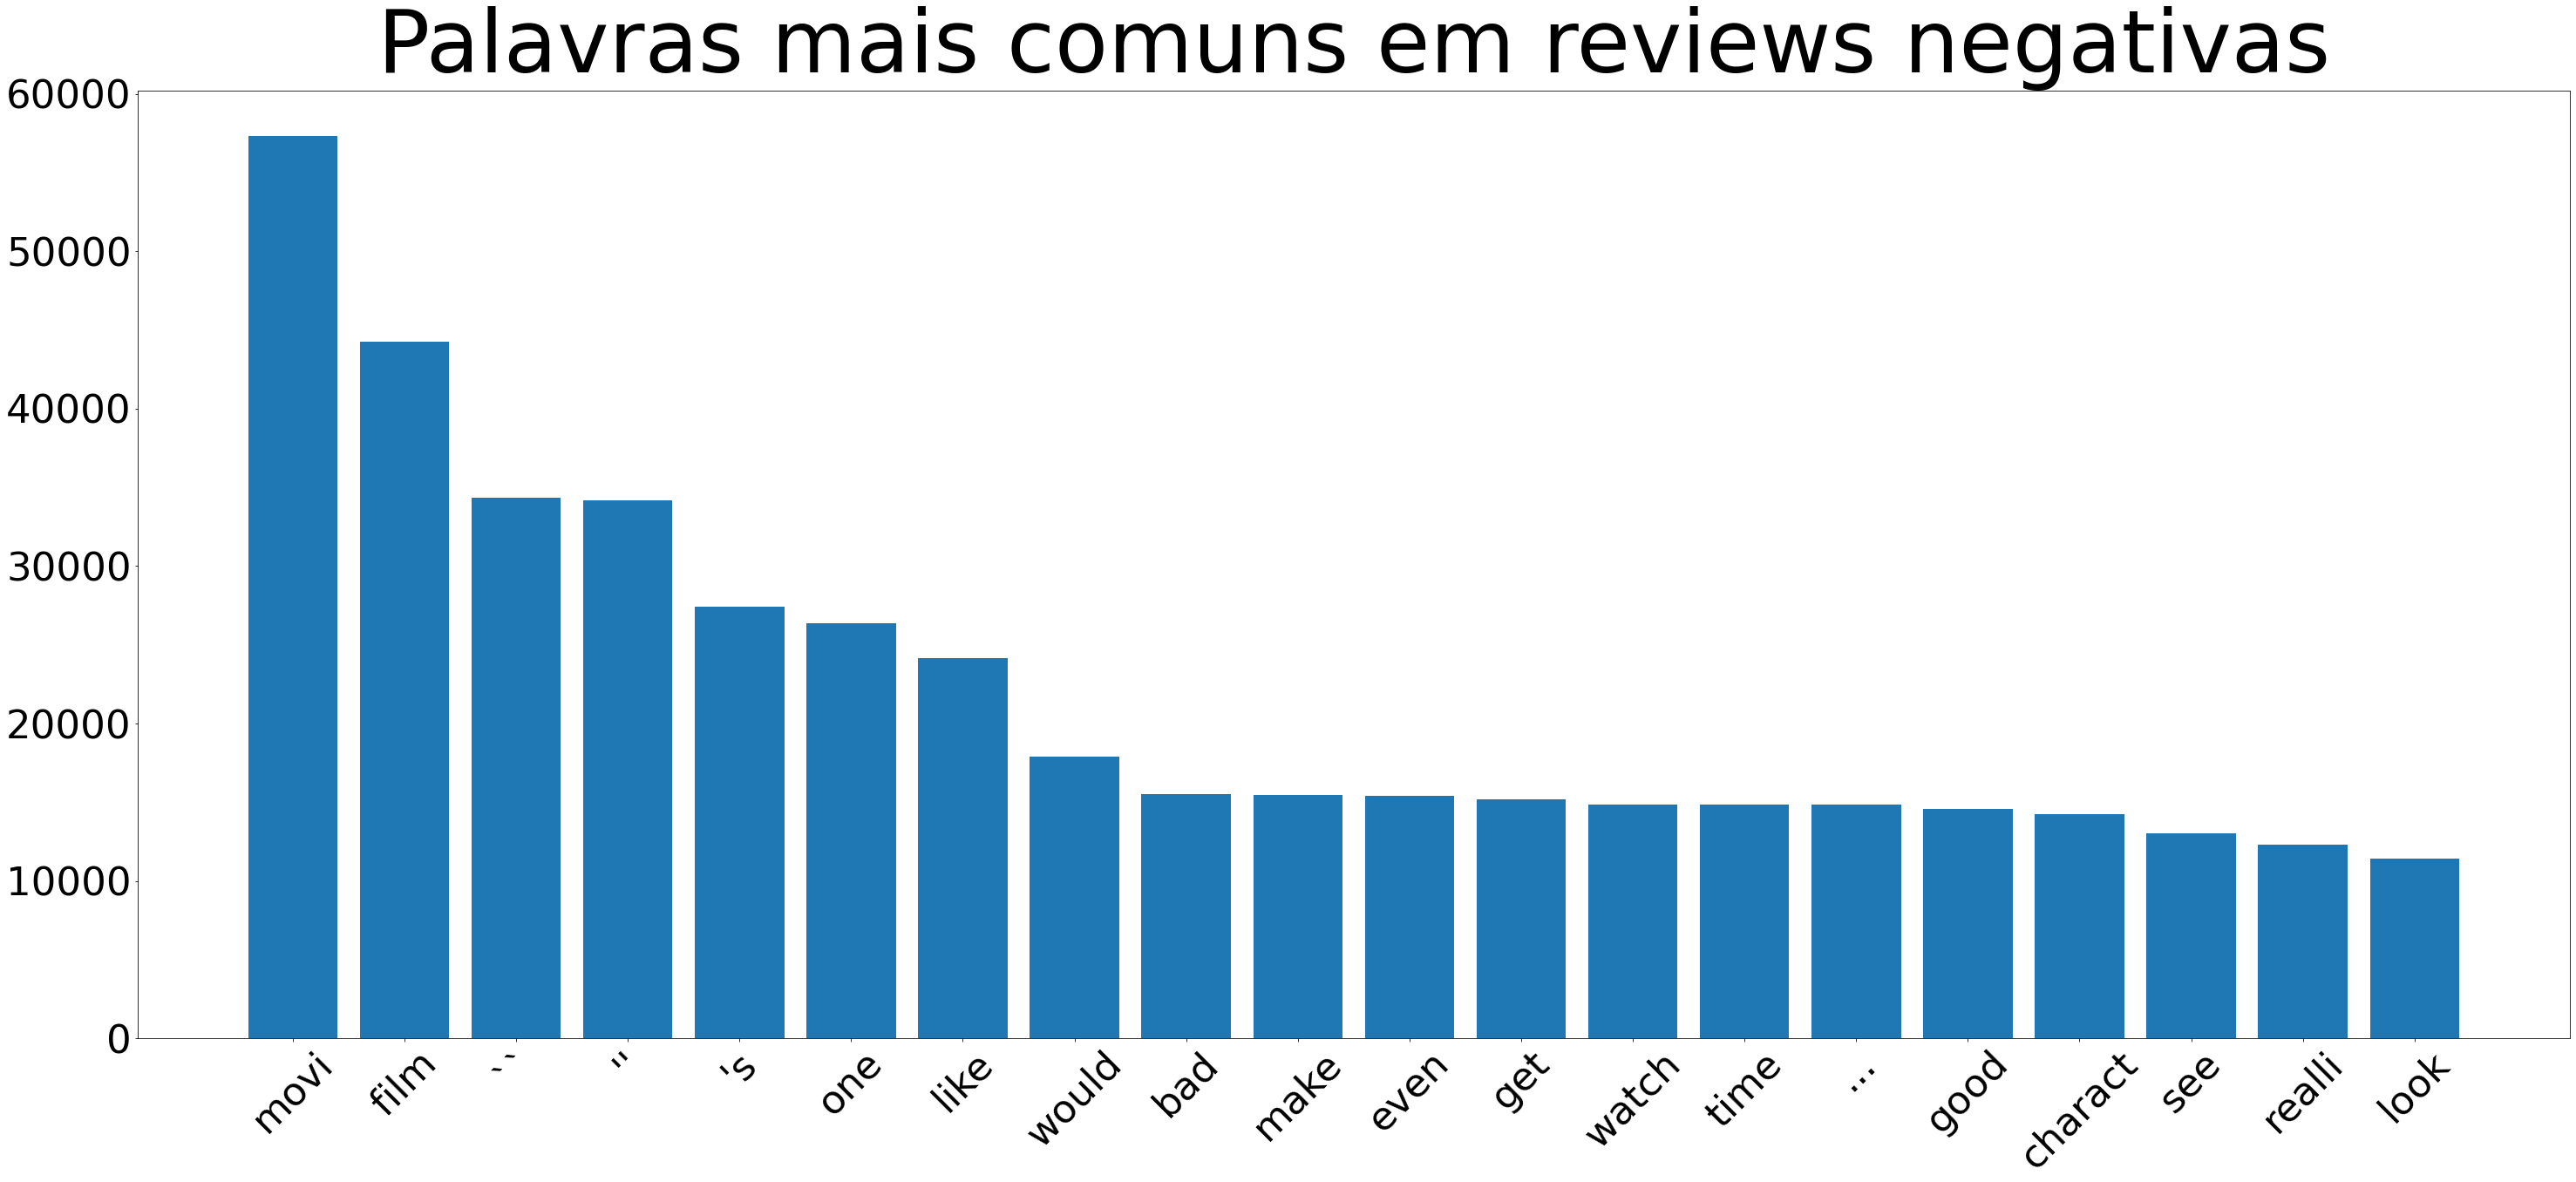

In [ ]:
plotCommonWords(negative_common_words[0:20], 'Palavras mais comuns em reviews negativas')

In [ ]:
#salvando o novo data frame
#df.to_parquet('processed_imdb.pkl')

Próximos passos:
- Limpar ainda mais o conjunto
- Modelagem dos dados (CountVectorizer, TF-IDF, word2vec)
- Obter um bom classificador

-
- Testar generalização aplicando em outros conjuntos

In [ ]:
df.head()

,review,sentiment,no_contract,review_description_str,tokenized,lower,no_punc,stopwords_removed,stemmed
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...",One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooke...,"[One, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, Oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, 1, oz, episode, yo...","[one, reviewers, mentioned, watching, 1, oz, episode, hooked, right, exactly, happened, first, t...","[one, review, mention, watch, 1, oz, episod, hook, right, exact, happen, first, thing, struck, o..."
1,A wonderful little production. The filming technique is very unassuming- very old-time-BBC f...,positive,"[A, wonderful, little, production., The, filming, technique, is, very, unassuming-, very, old-ti...",A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashi...,"[A, wonderful, little, production, ., The, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, ., the, filming, technique, is, very, unassuming-, very, old-...","[a, wonderful, little, production, the, filming, technique, is, very, unassuming-, very, old-tim...","[wonderful, little, production, filming, technique, unassuming-, old-time-bbc, fashion, gives, c...","[wonder, littl, product, film, techniqu, unassuming-, old-time-bbc, fashion, give, comfort, some..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,"[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend,, s...","I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...","[I, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, ,,...","[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, si...","[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater,...","[thought, wonder, way, spend, time, hot, summer, weekend, sit, air, condit, theater, watch, ligh..."
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,"[Basically, there is, a, family, where, a, little, boy, (Jake), thinks, there is, a, zombie, in,...",Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & h...,"[Basically, there, is, a, family, where, a, little, boy, (, Jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, (, jake, ), thinks, there, is, a, zombi...","[basically, there, is, a, family, where, a, little, boy, jake, thinks, there, is, a, zombie, in,...","[basically, family, little, boy, jake, thinks, zombie, closet, parents, fighting, time, movie, s...","[basic, famili, littl, boy, jake, think, zombi, closet, parent, fight, time, movi, slower, soap,..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,"[Petter, Mattei's, ""Love, in, the, Time, of, Money"", is, a, visually, stunning, film, to, watch....","Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...","[Petter, Mattei, 's, ``, Love, in, the, Time, of, Money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually, stunning, film, to...","[petter, mattei, 's, ``, love, in, the, time, of, money, '', is, a, visually,

In [ ]:
# Pegando só as palavras alfas (pra retirar símbolos...)
df['cleaner'] = df['stemmed'].apply(lambda x: [word for word in x if word.isalpha()])
df['cleaner'].head()

0    [one, review, mention, watch, oz, episod, hook, right, exact, happen, first, thing, struck, oz, ...
1    [wonder, littl, product, film, techniqu, fashion, give, comfort, sometim, discomfort, sens, real...
2    [thought, wonder, way, spend, time, hot, summer, weekend, sit, air, condit, theater, watch, come...
3    [basic, famili, littl, boy, jake, think, zombi, closet, parent, fight, time, movi, slower, soap,...
4    [petter, mattei, love, time, money, visual, stun, film, watch, mattei, offer, us, vivid, portrai...
Name: cleaner, dtype: object

In [ ]:
df['cleaner_str'] = [' '.join(map(str,l)) for l in df['cleaner']]

In [ ]:
# Fazendo a recontagem das palavras
reviews_tokens = df['cleaner']
all_words = []
for review in reviews_tokens:
  all_words += review

print(len(all_words))
print(all_words[0:100])

5719184
['one', 'review', 'mention', 'watch', 'oz', 'episod', 'hook', 'right', 'exact', 'happen', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'main', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget', 'charm']


In [ ]:
common_words = FreqDist(all_words).most_common(100)
print(common_words[0:10])

[('movi', 101477), ('film', 94357), ('one', 54020), ('like', 44234), ('would', 31019), ('time', 30866), ('good', 29482), ('make', 28713), ('charact', 28112), ('see', 27902)]


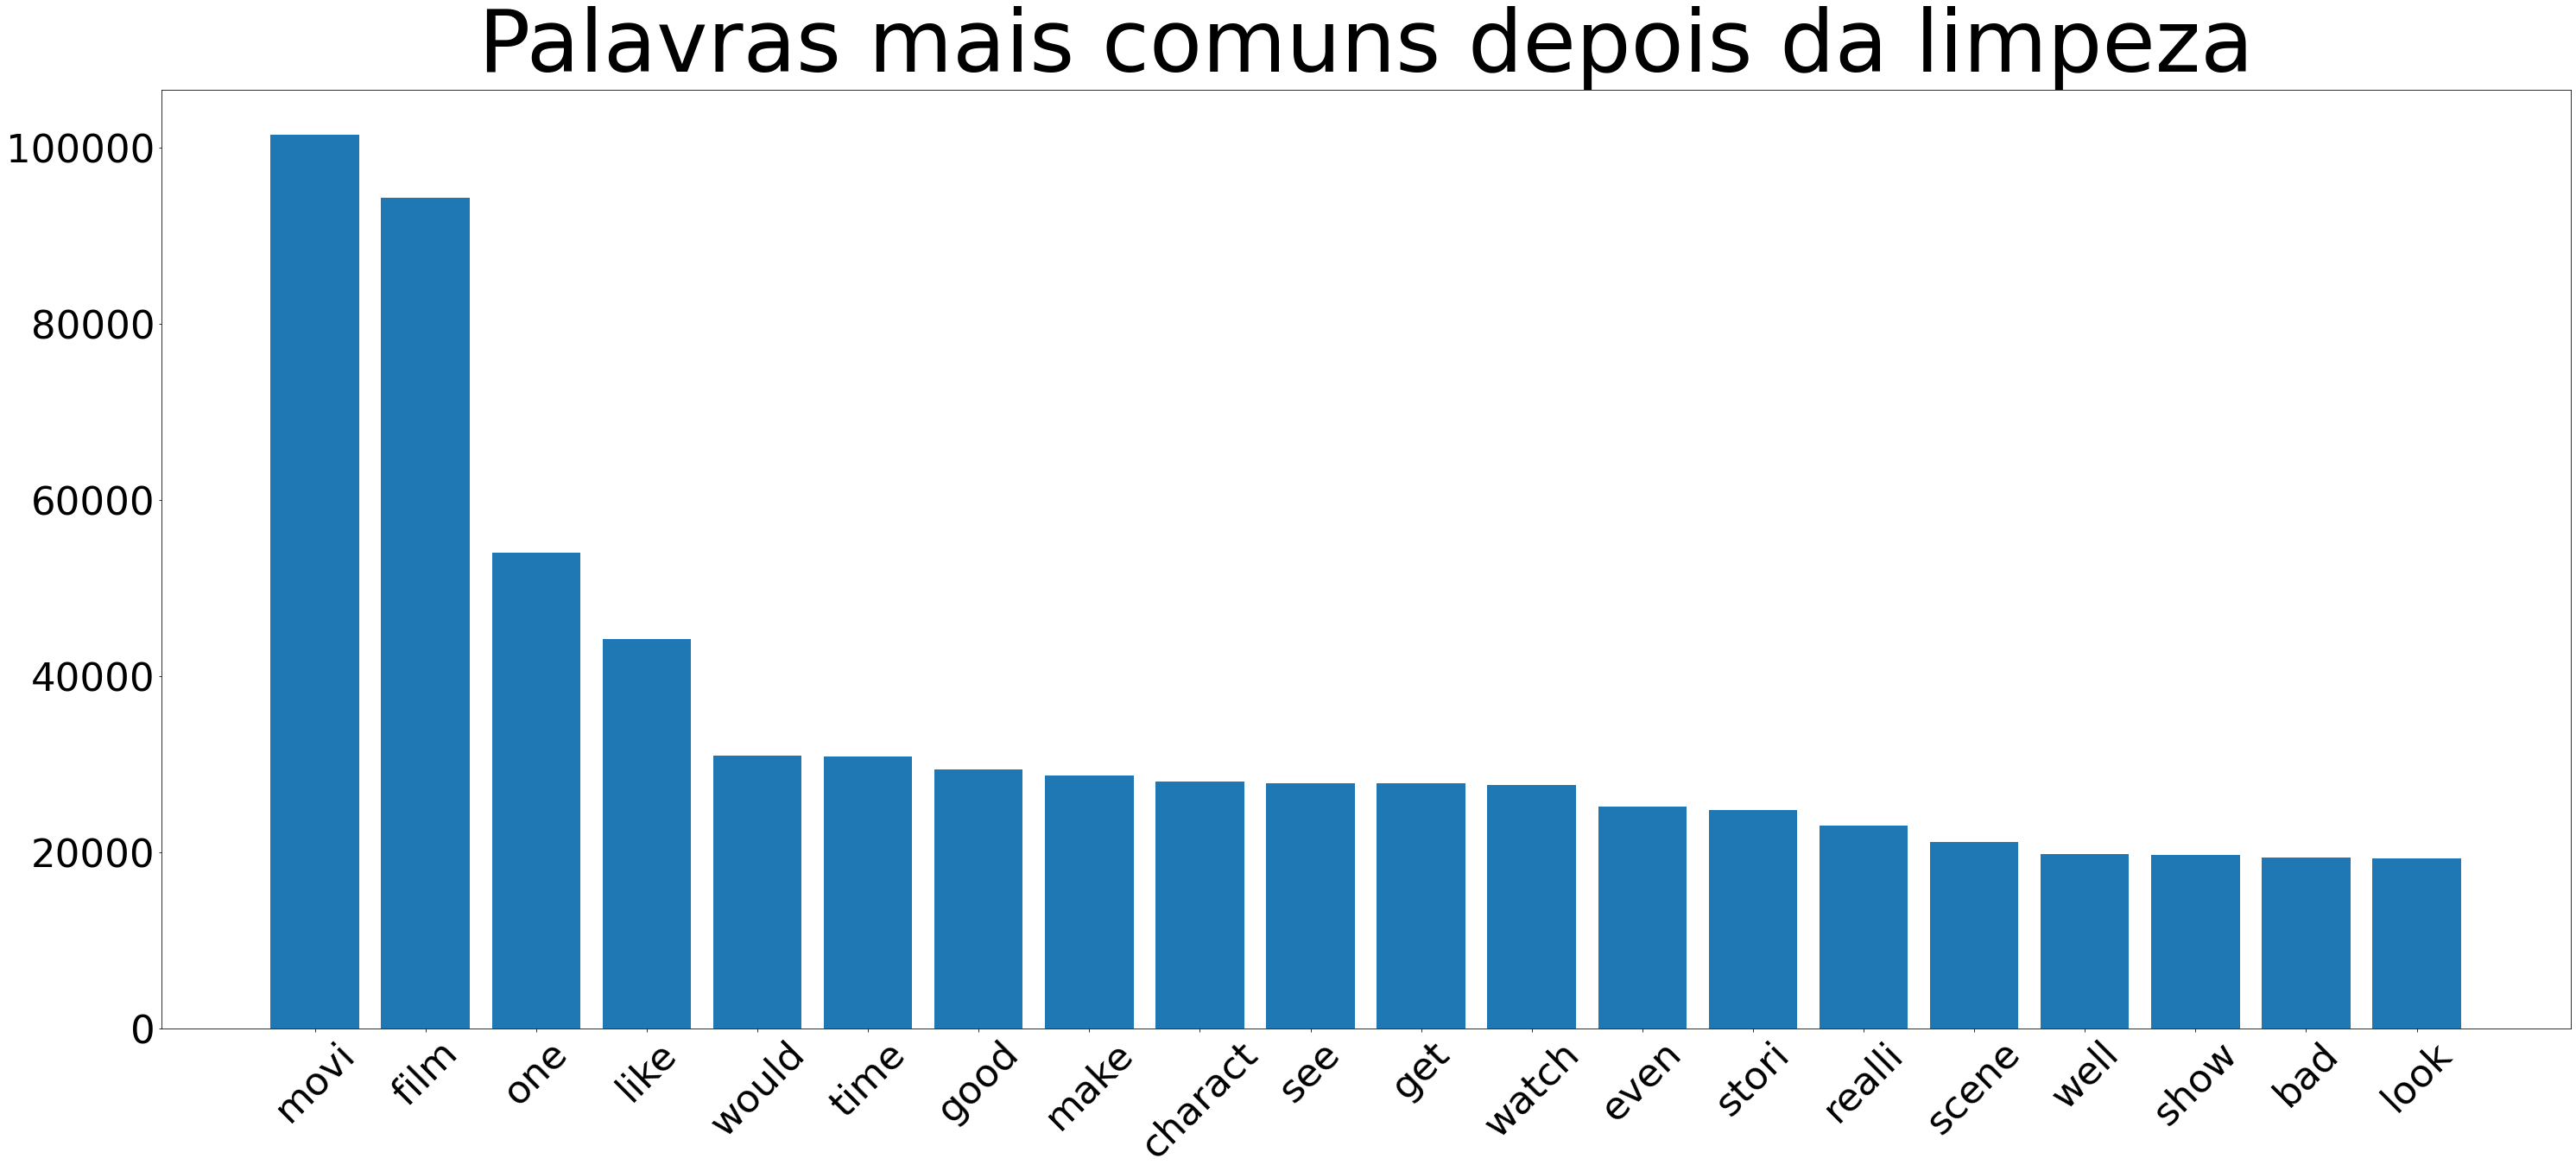

In [ ]:
plotCommonWords(common_words[0:20], 'Palavras mais comuns depois da limpeza')

In [ ]:
df.columns

Index(['review', 'sentiment', 'no_contract', 'review_description_str',
       'tokenized', 'lower', 'no_punc', 'stopwords_removed', 'stemmed',
       'cleaner', 'cleaner_str'],
      dtype='object')

In [ ]:
df[['review', 'sentiment', 'cleaner', 'cleaner_str']].to_csv('imdb_cleaned.csv')

In [ ]:
from google.colab import drive
#drive.mount('drive')
!cp imdb_cleaned.csv "drive/My Drive/"

In [ ]:
# JOGAMOS A PARTE DE BAIXO PARA OUTRO NOTEBOOK

#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

In [ ]:
# Fazendo vetorização TF-IDF
#vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform(df['cleaner_str'])

In [ ]:
# Rodar isso faz o Colab crashar
#tfidf_feature_names = vectorizer.get_feature_names()
#doc_term_matrix_tfidf = pd.DataFrame(X.toarray(), columns=list(tfidf_feature_names))

In [ ]:
# Testando usando uma Random Forest
#X_train, X_val, y_train, y_val = train_test_split(
#    X, df.sentiment, train_size = 0.8
#)
#rf = RandomForestClassifier(n_estimators=500)
#rf.fit(X_train, y_train)
#print ("Accuracy: %s" 
#       % accuracy_score(y_val, rf.predict(X_val)))